# Subscriptions API: Land Surface Temperature Planetary Variable Workflow
The Planetary Variable Land Surface Temperature (LST) offers a high-quality, reliable dataset to better model weather systems and improve decision-making. This tutorial will walk you through how to use the Planet Subscriptions APIs to retrieve Land Surface Temperature data at 100m resolution. You examples on how to plot timeseries of average values and how to create maps with the raster data.
<br> <br>
For the raster/geotiff section, we are using Google Cloud Platform (GCP). You can adjust the code to use your chosen cloud storage provider as required.

## Requirements

This tutorial assumes familiarity with the [Python](https://python.org) programming language throughout, with two additional packages, rioxarray and matplotlib. Python modules used in this tutorial are:
* [IPython](https://ipython.org/) and [Jupyter](https://jupyter.org/)
* [planet-python-client](https://github.com/planetlabs/planet-client-python)
* [rioxarray](https://corteva.github.io/rioxarray/html/installation.html)
* [matplotlib](https://matplotlib.org/)

You should also have an account on the Planet Platform. You will login to create an access token that authenticates your API key from the [account page](https://www.planet.com/account/). Addtionally, you need to have access to the `LST-AMSR2_V1.0_100` product - your area of access will define which geometry to use for this example walkthrough.

## Useful links 
* [Planet SDK and Developer Resources](https://docs.planet.com/develop/sdks/#planet-sdk-for-python-and-cli/)
* [Planet Python Client Repo](https://github.com/planetlabs/planet-client-python)
* [Planet Subscriptions API Documentation](https://docs.planet.com/develop/apis/subscriptions/)
* [Subscribing to Planetary Variables](https://developers.planet.com/docs/subscriptions/pvs-subs/)
* [Planet Land Surface Tempertature Documentation](https://docs.planet.com/data/planetary-variables/land-surface-temperature/)

### Subscriptions Delivery 

**Note that the first part of this notebook covers a metadata subscription delivery that does *not* require a cloud bucket. Any subscription that delivers raster data however, will require cloud storage or hosting.**
<br> <br>
For Subscriptions, local delivery is not supported and subscriptions must be delivered to a cloud bucket or hosting service. For details on delivery schema for the supported cloud delivery platforms, see the [Subscriptions API Delivery Documentation](https://developers.planet.com/docs/subscriptions/delivery/).
<br>
<br>

Valid Cloud platforms include:
 - Google Cloud Storage (used in this tutorial)
 - Google Earth Engine 
 - Amazon S3 (and other services that use the S3 API)
 - Oracle Cloud Storage
 - Microsoft Azure
<br>
Subscriptions can also use the data hosting feature on Sentinel Hub/Planet Insights Platform, and 'hosting' is used instead of 'delivery' in API calls.
<br>

Regardless of the platform you're using, ensure that you have **both write and delete access** to your storage location.

___

## Setup

In order to interact with the Planet API using the Python client, we need to authenticate our Planet account credentials and import the necessary packages.

In [ ]:
import base64
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio
import rioxarray as rx
import xarray as xr

from datetime import datetime
from io import StringIO

from planet import Auth, Session, Planet, subscription_request

### SDK Authentication

We need to create an OAuth2 access token using our Planet login for python client access. 
If you are not currently logged in to your Planet account, you will be prompted via a login link to do so. 
For more information, please visit Planets [API Authentication Documentation](https://docs.planet.com/develop/authentication)

In [2]:
# OAuth2 python client authentication
# If you are not already logged in, this will prompt you to open a web browser to log in.

auth = Auth.from_profile('planet-user', save_state_to_storage=True)
if not auth.is_initialized():
    auth.user_login(allow_open_browser=False, allow_tty_prompt=True)

session = Session(auth)
pl = Planet(session)

____

## Creating your subscription
This first example creates a subscription for 4 years of 100m resolution LST data over the agricultural area of Imperial, Nebraska.

Subscriptions can be created with or without a delivery parameter, which specifies a storage location to deliver raster data. For this first analysis we do not require raster assets, so the delivery parameter has been omitted to create a metadata-only subscription.

#### Define your AOI
In your [Planet account dashboard](https://www.planet.com/account/#/dashboard), you can check your provisioned data - for this walkthrough, you will need to have access to the LST 100m data product. If the example location (Nebraska, USA) is not within your area of access, you can define a new area of interest (AOI) that you would like to use for testing.

**Tip:** You can use the tool [GeoJSON.io](https://geojson.io/#map=2/0/20) to create an AOI geometry to use as per the example below.

In [3]:
geometry = {"coordinates": [[
    [-101.43539213886689, 40.709547875828804],
    [-101.43539213886689, 40.52787626066092],
    [-101.1076439548855, 40.52787626066092],
    [-101.1076439548855, 40.709547875828804],
    [-101.43539213886689, 40.709547875828804]
   ]],
 "type": "Polygon"}

You can instead load a geometry directly from a GeoJSON file, for example:

In [ ]:
# Get the geometry from a geojson file
fname = "my_geometry.geojson"
with open(fname, "r") as file:
    geojson_data = json.load(file)
geometry = geojson_data["features"][0]

#### Build your Metadata Subscription

**WARNING: Creating a Request below will consume quota! Be sure about the filter params so you can create a useful subscription. The variables below are meant as placeholders.**

In order to create a subscription using the Python Client, we must provide a subscription description dictionary. This will include a `name`, `source` block. Subscriptions also support select tools. We will accomplish this all using `subscription_source()` for the source block, and `build_request()` to complete the request block.

In [ ]:
source_id = "LST-AMSR2_V1.0_100"
subscription_name = "LST_100m_Imperial-Nebraska"
start_time = datetime.fromisoformat("2020-01-01T00:00:00Z")
end_time = datetime.fromisoformat("2024-01-01T00:00:00Z")

pv_source = subscription_request.subscription_source(source_id, geometry, start_time, end_time)
pv_sub = subscription_request.build_request(subscription_name, pv_source) 

In [ ]:
pv_sub

#### Create the subscription
Using the [create_subscription](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.subscriptions.SubscriptionsClient.create_subscription) method, we POST the request defined above to `https://api.planet.com/subscriptions/v1`

In [ ]:
metadata_sub = pl.subscriptions.create_subscription(pv_sub)

In [ ]:
metadata_sub

#### Monitor the subscription
We now monitor the progress of the subscription with the [get_subscription](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.subscriptions.SubscriptionsClient.get_subscription) method (subscription status is explained in further detail [here](https://developers.planet.com/docs/subscriptions/#subscription-status))

In [ ]:
subscription_id = metadata_sub['id']

In [ ]:
subscription_check = pl.subscriptions.get_subscription(subscription_id)
print(f'subscription id {subscription_check['id']} status is {subscription_check['status']}')

#### Retrieve the data
We can start retrieving the subscription data even if the status is 'running'. The `metadata-only` (timeseries) results generated for this subscription is retrieved directly in CSV format with `get_results_csv`. We can use the Pandas library to read this into a DataFrame to perform further analysis and to create a nice time series visualization.

In [ ]:
results_desc = pl.subscriptions.get_results_csv(subscription_id)
results_desc_list = [result for result in results_desc]

In [ ]:
# StringIO is treating the text string output of get_results_csv as a csv file
results_df = pd.read_csv(
    StringIO("\n".join(results_desc_list)),
    parse_dates=["item_datetime", "local_solar_time"],
                 index_col="local_solar_time",)
results_df.head(5)

### Temporal Analysis

Now, we are ready to analyze the average temperature of the agricultural region over time. Two time series plots are created: one for nighttime observations (captured at 01:30 solar time) and one for daytime observations (captured at 13:30 solar time). A rolling backward windows average is also plotted to show the 10 days trend. When the subscription is completed, this will be a full record of the temperature data over the four years requested.

In [ ]:
backward_average_window_size=10

# Plot the Land Surface Temperature time-series for nighttime observations
results_df.between_time("1:15", "1:45")["lst.band-1.mean"].plot(
    grid=True, style="c.", alpha=0.4, label="Night Observations", figsize=(15, 4)
)
results_df["average"] = results_df.between_time("1:15", "1:45")["lst.band-1.mean"].rolling(
    window=pd.Timedelta(days=backward_average_window_size), min_periods=1, center=False, closed=None
    ).mean()[backward_average_window_size - 1:].plot(
    grid=True,
    style="c-",
    label=f"{backward_average_window_size} nights rolling averaged",
    figsize=(15, 4)
)

# Plot the Land Surface Temperature time-series for daytime observations
results_df.between_time("13:15", "13:45")["lst.band-1.mean"].plot(
    grid=True, style="r.", alpha=0.4, label="Day Observations", figsize=(15, 4)
)

results_df["average"] = results_df.between_time("13:15", "13:45")["lst.band-1.mean"].rolling(
    window=pd.Timedelta(days=backward_average_window_size), min_periods=1, center=False, closed=None
    ).mean()[backward_average_window_size - 1:].plot(
    grid=True, style="r-", label=f"{backward_average_window_size} days rolling averaged", figsize=(15, 4)
)

# Extra information for the visualization
plt.ylabel("Land Surface Temperature (K)", size = 10)
plt.xlabel("Date", size = 10)
plt.title(f"Land Surface Temperature {subscription_name}", size = 15)
plt.legend(ncols=4)

______

## Subscription with Raster delivery
In addition to providing metadata over an Area of Interest, you can also configure the delivery of raster results directly to a cloud storage location. We will use the same method as above to generate the request but now provide an additional `delivery` configuration. In this example, we will now focus on the month of July 2022.

#### Cloud Delivery Parameters:

 Your delivery or hosting parameters may be specified here. Below is a template for delivery to a Google Cloud Storage bucket. Note that you will need a serivce account with create, delete, and get persmissions. See the [Google Cloud documentation](https://cloud.google.com/iam/docs/keys-create-delete#iam-service-account-keys-create-console) on how to create a service account key with the appropriate permissions. It is recommended to set the GCS credentials as an environment variable; more information is available [here](https://docs.planet.com/develop/apis/subscriptions/delivery/#google-cloud-storage). 
 <br> <br>
 Other options may be found with `subscription_request.amazon_s3`, `subscription_request.oracle_cloud_storage`, etc...


In [4]:
# Google Cloud Storage placeholder
gcs_key = os.getenv('gcs_private_key')
bucket_name = 'bucket_name'

# optional path_prefix
path_prefix = ''
bucket_delivery = subscription_request.google_cloud_storage(credentials=gcs_key, bucket=bucket_name, path_prefix=path_prefix)

In [ ]:
list(pl.subscriptions.list_subscriptions())

#### Build your Subscription

In [ ]:
subscription_name = "LST_100m Imperial Nebraska July 2022"
source_id = "LST-AMSR2_V1.0_100"
start_time_raster = datetime.fromisoformat("2022-07-01T00:00:00Z")
end_time_raster = datetime.fromisoformat("2022-08-01T00:00:00Z")


pv_source_raster = subscription_request.subscription_source(source_id, geometry, start_time_raster, end_time_raster)
pv_sub_raster = subscription_request.build_request(subscription_name, pv_source_raster, delivery=bucket_delivery) 

#### Create your Raster Subscription

In [ ]:
raster_sub = pl.subscriptions.create_subscription(pv_sub_raster)

In [ ]:
raster_sub

#### Check your Raster subscription
Lets check to make sure our raster subscription was delivered using the ID from the output of `create_subscription`. We will be using the subscription_id from it for the following Spatial Analysis.

In [ ]:
subscription_id = raster_sub['id']
pl.subscriptions.get_subscription(subscription_id)

____

## Spatial Analysis
The geotiff (raster) files will now be delivered to our Cloud Storage bucket.

The rioxarray extension to [rasterio](https://rasterio.readthedocs.io/en/latest/installation.html) can be used to open and map the delivered GeoTIFF files directly from their cloud storage location.

Rasterio uses GDAL under the hood, which supports accessing [network based file systems](https://gdal.org/user/virtual_file_systems.html#network-based-file-systems) across different cloud providers. For more information, see:

- [Amazon Web Service](https://gdal.org/user/virtual_file_systems.html#vsis3-aws-s3-files)
- [Google Cloud](https://gdal.org/user/virtual_file_systems.html#vsigs-google-cloud-storage-files)
- [Microsoft Azure](https://gdal.org/user/virtual_file_systems.html#vsiaz-streaming-microsoft-azure-blob-files-streaming)

In the following example, the data is read directly from our previously configured Google Cloud Storage bucket to visualize the Land Surface Temperature 100m resolution map over our AOIs on the 18th of July, 2022.

In [5]:
# To connect to Google Cloud Storage, we will need to provide the path to the json of our service accounts credentials

google_application_credentials = "path/to/credentials/json.json"

In [7]:
# Set the filepath to the 18 July 2022 GeoTIFF asset

date = "2022-07-18"
lst_file_location = f"gs://{bucket_name}/{subscription_id}/{date.replace('-','/')}/LST-AMSR2_V1.0_100-{date.replace('-','')}T1330_lst.tiff"

#### Land Surface Temperature on July 18th 2022

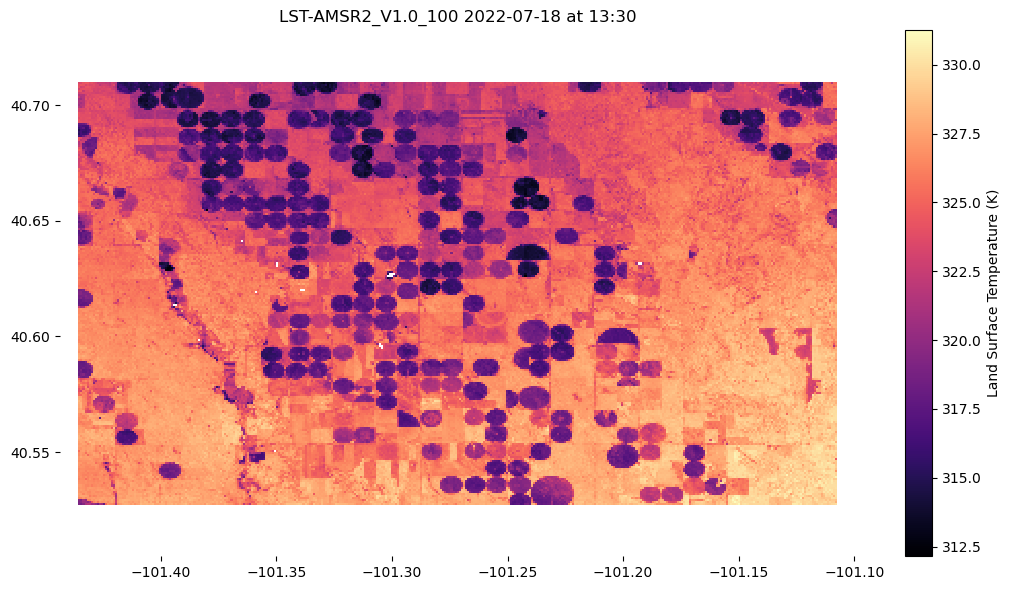

In [8]:
# Use the Cloud credentials to allow access to the storage location

with rasterio.env.Env(google_application_credentials=google_application_credentials):
    lst_data = rx.open_rasterio(lst_file_location, mask_and_scale=True, band_as_variable=True)

    lst_data = lst_data.rename_vars({
        "band_1":"Land Surface Temperature (K)",
        "band_2":"Masked LST values (K)",
    })

    aspect = lst_data["x"].size / lst_data["y"].size

    fig, ax = plt.subplots(figsize=(6*aspect, 6))
    lst_data["Land Surface Temperature (K)"].plot(ax=ax, cmap="magma", )

    ax.set_title(f"LST-AMSR2_V1.0_100 {date} at 13:30")
    ax.axis("equal")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_frame_on(False)
    plt.tight_layout()

#### Average Land Surface Temperature in the month of July 2022:

In the second spatial analysis, we open all the geotiffs between two dates into a xarray.DataSet and we compute the monthly average of temperature.

In [9]:
july_data = []
date_range = pd.date_range(start="2022-07-01", end="2022-07-31").strftime("%Y-%m-%d")

with rasterio.env.Env(google_application_credentials=google_application_credentials):
  for date in date_range:
    lst_file_location = f"gs://{bucket_name}/{subscription_id}/{date.replace('-','/')}/LST-AMSR2_V1.0_100-{date.replace('-','')}T1330_lst.tiff"
    july_data.append(rx.open_rasterio(lst_file_location, mask_and_scale=True, band_as_variable=True).assign_coords({"date": date}))

timeseries = xr.concat(july_data, dim="date")
timeseries['date'] = pd.DatetimeIndex(timeseries['date'].values)
timeseries = timeseries.rename_vars({
    "band_1":"Land Surface Temperature (K)",
    "band_2": "Masked LST values (K)",
})

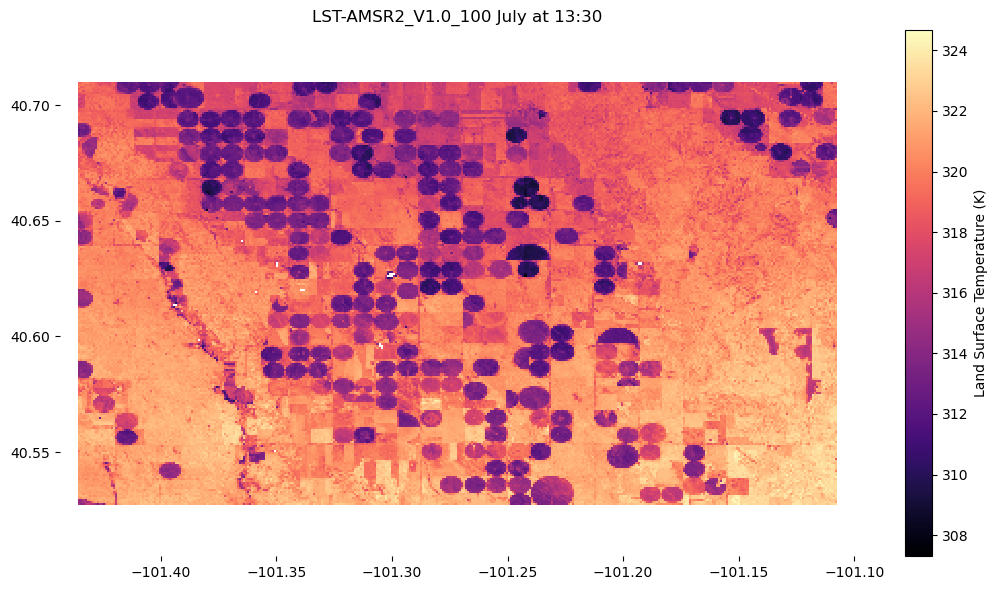

In [15]:
average = timeseries.resample(date="ME").mean()

aspect = average["x"].size / average["y"].size

fig, ax = plt.subplots(figsize=(6*aspect, 6))
average["Land Surface Temperature (K)"].plot(ax=ax, cmap="magma", )

ax.set_title("LST-AMSR2_V1.0_100 July at 13:30")
ax.axis('equal')
ax.set_frame_on(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()

Finally, we save the LST averaged map locally as a geotiff.

In [14]:
raster_path = os.path.join(os.getcwd(), "LST-AMSR2_V1.0_100_July_1330.tiff")
average["Land Surface Temperature (K)"].rio.to_raster(raster_path)
print(f"output raster to {raster_path}")

output raster to /home/jovyan/work/jupyter-notebooks/Subscriptions-API/LST-AMSR2_V1.0_100_July_1330.tiff


## Congratulations!

You now have all the tools you need to create and edit your own subscriptions to LST using our Subscriptions API Client tool. For more information on our subscriptions API, please check out our [Subscriptions API  Documentation](https://developers.planet.com/docs/subscriptions/)